https://python-programming.quantecon.org/parallelization.html

In [2]:
%matplotlib inline
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
n = 20
m = 1000
for i in range(n):
    X = np.random.randn(m, m)
    λ = np.linalg.eigvals(X)

In [4]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 5000)
x, y = np.meshgrid(grid, grid)

In [5]:
%timeit np.max(f(x, y))

1.12 s ± 97.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
from numba import vectorize

@vectorize
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

np.max(f_vec(x, y))  # Run once to compile

0.9999992797121728

In [7]:
%timeit np.max(f_vec(x, y))

171 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
@vectorize('float64(float64, float64)', target='parallel')
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

np.max(f_vec(x, y))  # Run once to compile

0.9999992797121728

In [9]:
%timeit np.max(f_vec(x, y))

242 ms ± 56.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
from numpy.random import randn
from numba import njit

@njit
def h(w, r=0.1, s=0.3, v1=0.1, v2=1.0):
    """
    Updates household wealth.
    """

    # Draw shocks
    R = np.exp(v1 * randn()) * (1 + r)
    y = np.exp(v2 * randn())

    # Update wealth
    w = R * s * w + y
    return w

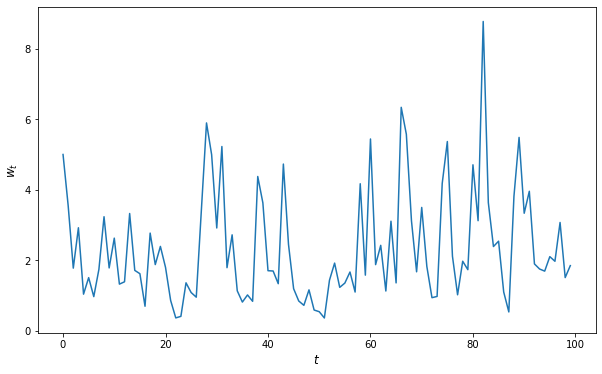

In [11]:
fig, ax = plt.subplots()

T = 100
w = np.empty(T)
w[0] = 5
for t in range(T-1):
    w[t+1] = h(w[t])

ax.plot(w)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$w_{t}$', fontsize=12)
plt.show()

In [12]:
@njit
def compute_long_run_median(w0=1, T=1000, num_reps=50_000):

    obs = np.empty(num_reps)
    for i in range(num_reps):
        w = w0
        for t in range(T):
            w = h(w)
        obs[i] = w

    return np.median(obs)

In [13]:
%%time
compute_long_run_median()

Wall time: 5.39 s


1.8443642764806947

In [14]:
from numba import prange

@njit(parallel=True)
def compute_long_run_median_parallel(w0=1, T=1000, num_reps=50_000):

    obs = np.empty(num_reps)
    for i in prange(num_reps):
        w = w0
        for t in range(T):
            w = h(w)
        obs[i] = w

    return np.median(obs)

In [15]:
%%time
compute_long_run_median_parallel()

Wall time: 1.45 s


1.8344831290686674

In [16]:
# ex1
from random import uniform

@njit(parallel=True)
def calculate_pi(n=1_000_000):
    count = 0
    for i in prange(n):
        u, v = uniform(0, 1), uniform(0, 1)
        d = np.sqrt((u - 0.5)**2 + (v - 0.5)**2)
        if d < 0.5:
            count += 1

    area_estimate = count / n
    return area_estimate * 4  # dividing by radius**2

In [17]:
%time calculate_pi()

Wall time: 501 ms


3.141752

In [18]:
%time calculate_pi()

Wall time: 12 ms


3.139144